In [1]:
import os
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import random
import time
import json
from neural_network import neural_network
from ops import *
from evaluation import evaluation

# Loading Data

In [2]:
# training data
channel = 'channel_13'
t1_train = np.load('./Dataset/house1/Final/'+channel+'.npy')
mix_train = np.load('./Dataset/house1/Final/mix.npy')
t2_train = mix_train-t1_train
'''
tmp = scipy.io.loadmat('./Dataset/house1/mix_train.mat')
mix_train = np.transpose(tmp['mix_train'])
tmp = scipy.io.loadmat('./Dataset/house1/source1_train.mat')
t1_train = np.transpose(tmp['source1_train'])
tmp = scipy.io.loadmat('./Dataset/house1/source2_train.mat')
t2_train = np.transpose(tmp['source2_train'])
train_size = mix_train.shape[0]
'''

# test data
'''
tmp = scipy.io.loadmat('./mix_test.mat')
mix_test = np.transpose(tmp['mix_test'])
tmp = scipy.io.loadmat('./source1_test.mat')
t1_test = np.transpose(tmp['source1_test'])
tmp = scipy.io.loadmat('./source2_test.mat')
t2_test = np.transpose(tmp['source2_test'])
test_size = mix_test.shape[0]
'''

"\ntmp = scipy.io.loadmat('./mix_test.mat')\nmix_test = np.transpose(tmp['mix_test'])\ntmp = scipy.io.loadmat('./source1_test.mat')\nt1_test = np.transpose(tmp['source1_test'])\ntmp = scipy.io.loadmat('./source2_test.mat')\nt2_test = np.transpose(tmp['source2_test'])\ntest_size = mix_test.shape[0]\n"

# Setting

In [3]:
# Setting for dataset
input_size = 100
overlap = 50
whole_size = t1_train.shape[0] # the overall length of the energy
t1_train, _ = data_adjust(t1_train, input_size, overlap)
t2_train, _ = data_adjust(t2_train, input_size, overlap)
mix_train, train_size = data_adjust(mix_train, input_size, overlap)
# Setting
architecture = np.array([input_size, 1000, 1000, 1000, input_size])
batch_size = 200
LR = 0.001
EP = 100
activation_function = tf.contrib.keras.activations.elu
# Initialization
dnn = neural_network(architecture=architecture, batch_size=batch_size, LR=LR, activation_function=activation_function)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [4]:
# Restore trained models
#saver = tf.train.Saver()
#saver.restore(sess, './Models/'+channel+'_'+str(input_size)+".ckpt")

# Training for washing machine

In [5]:
MSE_train = []
MSE_test  = []
total_loss = 0
for ep in range(EP):
    start = time.time()
    # ------------------Training------------------
    shuffle = [i for i in range(train_size)]
    np.random.shuffle(shuffle)
    shuffle = shuffle_append(shuffle, train_size, batch_size)
    
    for idx in range(math.ceil(train_size/batch_size)):
        # input at the currenct iteration
        t1, t2, mix = get_batch(t1_train, t2_train, mix_train, shuffle[idx*batch_size:(idx+1)*batch_size], input_size, overlap)
        
        feed_dict = {
            dnn.mix: mix,
            dnn.t1: t1,
            dnn.t2: t2
        }
        
        # update parameters
        _, loss = sess.run([dnn.train_op, dnn.loss], feed_dict)
        total_loss = total_loss + loss
    total_loss = total_loss/(train_size/batch_size)
    MSE_train.append(total_loss)
    total_loss = 0
    '''
    # ------------------Testing------------------
    for idx in range(int(test_size/batch_size)):
        # input at the currenct iteration
        feed_dict = {
            dnn.mix: mix_test[idx*batch_size:(idx+1)*batch_size-1, :],
            dnn.t1: t1_test[idx*batch_size:(idx+1)*batch_size-1, :],
            dnn.t2: t2_test[idx*batch_size:(idx+1)*batch_size-1, :]
        }
        
        # update parameters
        loss = sess.run(dnn.loss, feed_dict)
        total_loss = total_loss + loss
    total_loss = total_loss/(test_size/batch_size)
    MSE_test.append(total_loss)
    total_loss = 0
    '''
    end = time.time()
    # ------------------Print------------------
    #print('Epoch: ', ep, 'Training Loss: ', MSE_train[-1], 'Testing Loss: ', MSE_test[-1], 'Time duration: ', end-start)
    print('Epoch: ', ep, 'Training Loss: ', MSE_train[-1], 'Time duration: ', end-start)
            
print('----------------End-----------------')

Epoch:  0 Training Loss:  8924.16770059 Time duration:  7.454822778701782
Epoch:  1 Training Loss:  8025.92253317 Time duration:  7.180089950561523
Epoch:  2 Training Loss:  7625.63647795 Time duration:  7.752001762390137
Epoch:  3 Training Loss:  7402.11289937 Time duration:  7.977357625961304
Epoch:  4 Training Loss:  7186.55005606 Time duration:  7.671887636184692
Epoch:  5 Training Loss:  6969.38998931 Time duration:  7.168630123138428
Epoch:  6 Training Loss:  6801.75985534 Time duration:  7.150536060333252
Epoch:  7 Training Loss:  6618.70684231 Time duration:  7.100879669189453
Epoch:  8 Training Loss:  6399.26812357 Time duration:  7.289465665817261
Epoch:  9 Training Loss:  6191.24658372 Time duration:  7.170065879821777
Epoch:  10 Training Loss:  6062.76529895 Time duration:  7.318460941314697
Epoch:  11 Training Loss:  5886.68824175 Time duration:  7.478884696960449
Epoch:  12 Training Loss:  5792.28181356 Time duration:  7.917570114135742
Epoch:  13 Training Loss:  5626.794

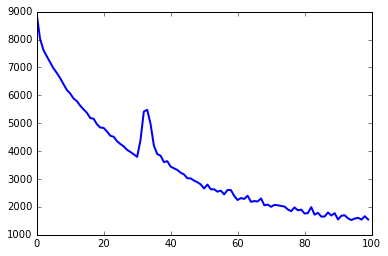

In [6]:
%matplotlib inline
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

ax.plot(MSE_train, linewidth=2)
plt.ion()
ax.plot(MSE_test, linewidth=2)
plt.show()

# Result

In [7]:
y1_train = []
y2_train = []
shuffle = [i for i in range(math.ceil(t1_train.shape[0]/input_size))]
shuffle = shuffle_append(shuffle, math.ceil(t1_train.shape[0]/input_size), batch_size)
for idx in range(math.ceil(train_size/batch_size)):
    _, _, mix = get_batch(t1_train, t2_train, mix_train, shuffle[idx*batch_size:(idx+1)*batch_size], input_size, input_size)
    feed_dict = {dnn.mix: mix}
    y1, y2 = sess.run([dnn.y1, dnn.y2], feed_dict)
    y1_train = y1_train + [y1]
    y2_train = y2_train + [y2]
y1_train, y2_train = unpack(y1_train, y2_train, input_size, whole_size)

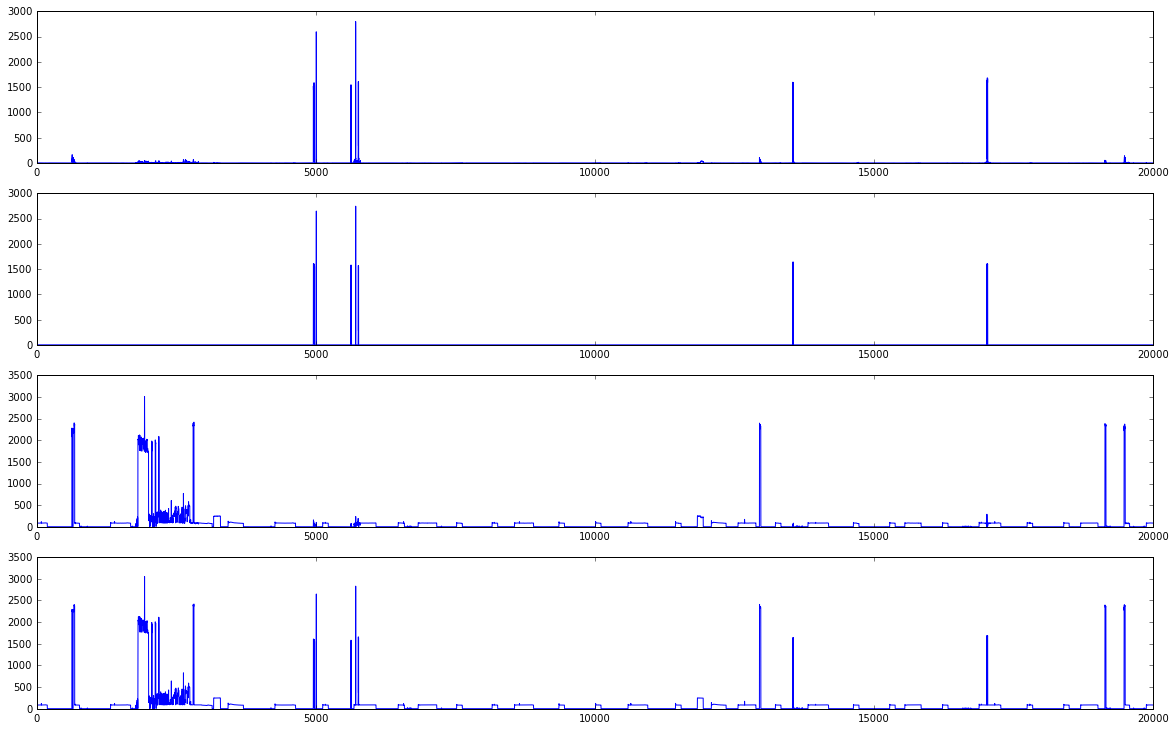

In [8]:
%matplotlib inline
fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 12.5)
ax  = [fig.add_subplot(4, 1, i) for i in range(1, 5)]
ax[0].plot(y1_train[1000000:1020000], linewidth=1, label='estimate')
ax[1].plot(t1_train[1000000:1020000, 1], linewidth=1, label='target1')
ax[2].plot(y2_train[1000000:1020000], linewidth=1, label='noise')
ax[3].plot(mix_train[1000000:1020000, 1], linewidth=1, label='mix')

# Saving

In [9]:
# Save the model
saver = tf.train.Saver()
save_path = saver.save(sess, './Models/'+channel+'_'+str(input_size)+".ckpt")

# Save the numpy mat
np.save('./Prediction/'+channel+'_'+str(input_size)+'.npy', np.array(y1_train))

# Evaluation

In [10]:
orig = np.load('./Dataset/house1/Final/'+channel+'.npy')
pred = np.load('./Prediction/'+channel+'_'+str(input_size)+'.npy')
aggre = np.load('./Dataset/house1/Final/mix.npy')
RETE, MAE, PTECA = evaluation(orig=orig[:, 1], pred=pred, aggre=aggre[:, 1])
print('Relative error in total energy', RETE)
print('Mean absolute error', MAE)
print('Proportion of total energy correctly assigned', PTECA)

Relative error in total energy 0.0327168588917
Mean absolute error 0.556163117758
Proportion of total energy correctly assigned 0.983686942954
